In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**1.BiLSTM(word 2 vec)**

In [ ]:
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from sklearn.metrics import precision_score, f1_score,recall_score

# Load the CSV file
data = pd.read_csv("/content/drive/MyDrive/merge_check.csv")

# Extract the text and label columns from the CSV
texts = data["Headline"].tolist()
texts = data["Content"].tolist()
labels = data["Label"].tolist()

# Initialize the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

# Preprocess your text data and convert it to sequences
sequences = tokenizer.texts_to_sequences(texts)

# Train Word2Vec model on your preprocessed text data
sentences = [text.split() for text in texts]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Convert each word to its corresponding word vector
embedding_matrix = np.zeros((len(word2vec_model.wv.key_to_index) + 1, 100))
for word, index in word2vec_model.wv.key_to_index.items():
    embedding_matrix[index] = word2vec_model.wv.get_vector(word)

# Convert text sequences to padded sequences
max_sequence_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Split the data into training, validation, and test sets
X_train, X_val_test, y_train, y_val_test = train_test_split(padded_sequences, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Convert labels to NumPy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)

# Define the BiLSTM model
model = Sequential()
model.add(Embedding(len(word2vec_model.wv.key_to_index) + 1, 100, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64)

# Evaluate the model
# Convert X_test and y_test to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

# Calculate precision and F1 score
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall=recall_score(y_test,y_pred)

print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall Score: {recall:.4f}")


Epoch 1/10
37/37 [==============================] - 148s 4s/step - loss: 0.6969 - accuracy: 0.5410 - val_loss: 0.6741 - val_accuracy: 0.5757
Epoch 2/10
37/37 [==============================] - 135s 4s/step - loss: 0.6406 - accuracy: 0.6340 - val_loss: 0.5783 - val_accuracy: 0.6713
Epoch 3/10
37/37 [==============================] - 139s 4s/step - loss: 0.5189 - accuracy: 0.7410 - val_loss: 0.4978 - val_accuracy: 0.7191
Epoch 4/10
37/37 [==============================] - 136s 4s/step - loss: 0.5172 - accuracy: 0.7363 - val_loss: 0.5534 - val_accuracy: 0.6833
Epoch 5/10
37/37 [==============================] - 133s 4s/step - loss: 0.5137 - accuracy: 0.7402 - val_loss: 0.5357 - val_accuracy: 0.7112
Epoch 6/10
37/37 [==============================] - 138s 4s/step - loss: 0.5029 - accuracy: 0.7483 - val_loss: 0.4889 - val_accuracy: 0.7371
Epoch 7/10
37/37 [==============================] - 133s 4s/step - loss: 0.5001 - accuracy: 0.7457 - val_loss: 0.5031 - val_accuracy: 0.7171
Epoch 8/10
37

16/16 [==============================] - 18s 1s/step


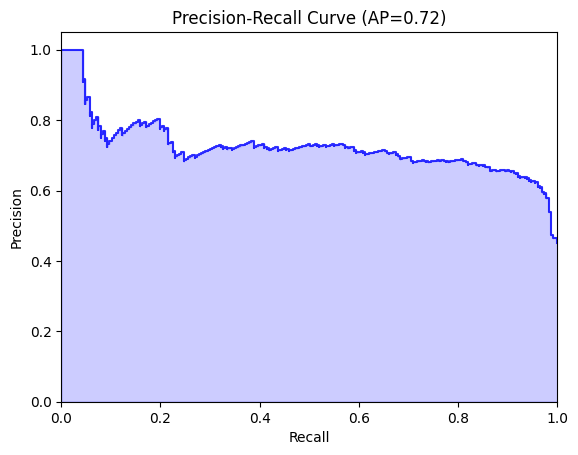

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt

# Generate precision-recall curve
y_pred_prob = model.predict(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
average_precision = auc(recall, precision)

# Plot the precision-recall curve
plt.figure()
plt.step(recall, precision, where='post', color='b', alpha=0.8)
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve (AP={0:0.2f})'.format(average_precision))
plt.show()

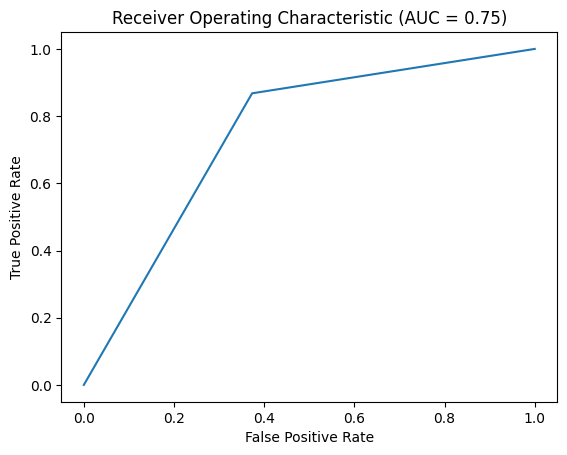

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming you have defined `y_test` and `y_pred` correctly
fpr, tpr, _ = roc_curve(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred)
# Plot ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (AUC = {:.2f})'.format(auc))
plt.show()

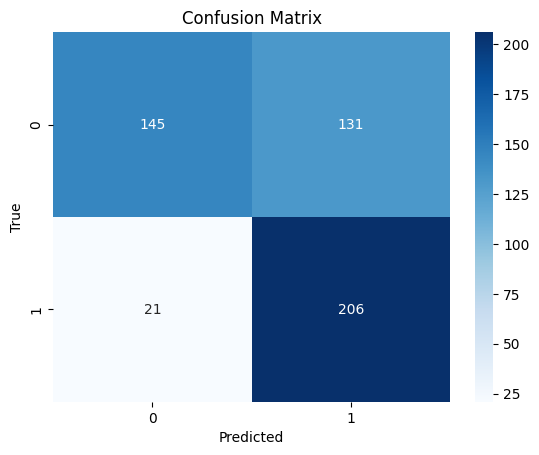

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.53      0.66       276
           1       0.61      0.91      0.73       227

    accuracy                           0.70       503
   macro avg       0.74      0.72      0.69       503
weighted avg       0.76      0.70      0.69       503



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Convert predicted probabilities to binary class labels
y_pred_binary = (y_pred > 0.5).astype(int)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Generate the classification report
report = classification_report(y_test, y_pred_binary)

# Create a heatmap of the confusion matrix
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and ticks
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")

# Show the plot
plt.show()

# Print classification report
print("Classification Report:")
print(report)

In [ ]:
pip install -U bnlp_toolkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 17.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 55.2 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171033 sha256=cc9946d101d0b6322a50752e54030f59d66e4db9708bc84c767e9b53fd1b592d
  Stored in directory: /root/.cache/pip/wheels/31/8a/8c/315c9e5d7773f74b33d5ed33f075b49c6eaeb7cedbb86e2cf8
Successfully built emoji


In [ ]:
from urllib.request import urlopen
import gzip

# get the vectors
file = gzip.open(urlopen('https://huggingface.co/sagorsarker/bangla_word2vec/blob/main/bangla_word2vec_gen4.zip'))

In [ ]:
import requests
import shutil

url = 'https://huggingface.co/sagorsarker/bangla_word2vec/raw/main/bangla_word2vec_gen4.bin.gz'
response = requests.get(url, stream=True)

model_path = '/content/drive/MyDrive/bangla_word2vec_gen4.zip'  # Set the desired file path here
with open(model_path, 'wb') as out_file:
    shutil.copyfileobj(response.raw, out_file)


In [ ]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/






**2.CNN(word_2_vec)**

In [ ]:
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from sklearn.metrics import precision_score, f1_score,recall_score

# Load the CSV file
data = pd.read_csv("/content/drive/MyDrive/merge_check.csv")

# Extract the text and label columns from the CSV
texts = data["Headline"] + " " + data["Content"]
labels = data["Label"].tolist()

# Initialize the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

# Preprocess your text data and convert it to sequences
sequences = tokenizer.texts_to_sequences(texts)

# Train Word2Vec model on your preprocessed text data
sentences = [text.split() for text in texts]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Convert each word to its corresponding word vector
embedding_matrix = np.zeros((len(word2vec_model.wv.key_to_index) + 1, 100))
for word, index in word2vec_model.wv.key_to_index.items():
    embedding_matrix[index] = word2vec_model.wv.get_vector(word)

# Convert text sequences to padded sequences
max_sequence_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Split the data into training, validation, and test sets
X_train, X_val_test, y_train, y_val_test = train_test_split(padded_sequences, labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Convert labels to NumPy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)

# Define the CNN model
model = Sequential()
model.add(Embedding(len(word2vec_model.wv.key_to_index) + 1, 100, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64)

# Evaluate the model
# Convert X_test and y_test to numpy arrays
X_test = np.array(X_test)
y_test = np.array(y_test)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

# Make predictions
y_pred = model.predict(X_test)
y_pred_binary = np.round(y_pred).flatten()

# Calculate precision and F1 score
precision = precision_score(y_test, y_pred_binary)
f1 = f1_score(y_test, y_pred_binary)
recall=recall_score(y_test,y_pred_binary)

print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall Score: {recall:.4f}")






Epoch 1/10
37/37 [==============================] - 17s 435ms/step - loss: 0.6903 - accuracy: 0.5631 - val_loss: 0.6485 - val_accuracy: 0.6056
Epoch 2/10
37/37 [==============================] - 16s 448ms/step - loss: 0.5980 - accuracy: 0.6668 - val_loss: 0.5996 - val_accuracy: 0.6554
Epoch 3/10
37/37 [==============================] - 18s 485ms/step - loss: 0.5571 - accuracy: 0.7154 - val_loss: 0.5517 - val_accuracy: 0.7291
Epoch 4/10
37/37 [==============================] - 18s 491ms/step - loss: 0.5379 - accuracy: 0.7184 - val_loss: 0.5441 - val_accuracy: 0.7410
Epoch 5/10
37/37 [==============================] - 17s 465ms/step - loss: 0.5501 - accuracy: 0.7090 - val_loss: 0.5450 - val_accuracy: 0.7470
Epoch 6/10
37/37 [==============================] - 24s 661ms/step - loss: 0.5124 - accuracy: 0.7398 - val_loss: 0.4989 - val_accuracy: 0.7570
Epoch 7/10
37/37 [==============================] - 16s 427ms/step - loss: 0.4798 - accuracy: 0.7683 - val_loss: 0.5227 - val_accuracy: 0.7032

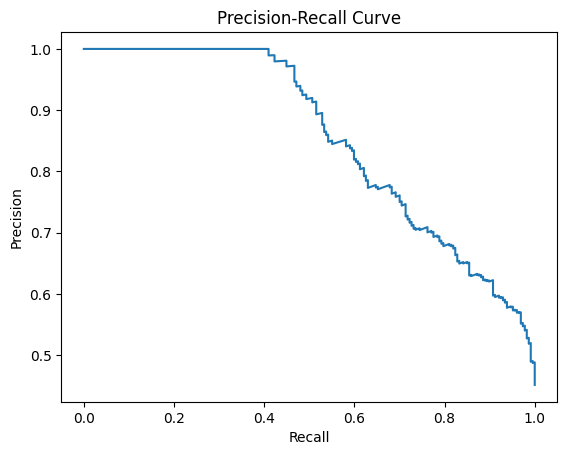

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, y_pred)

# Plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

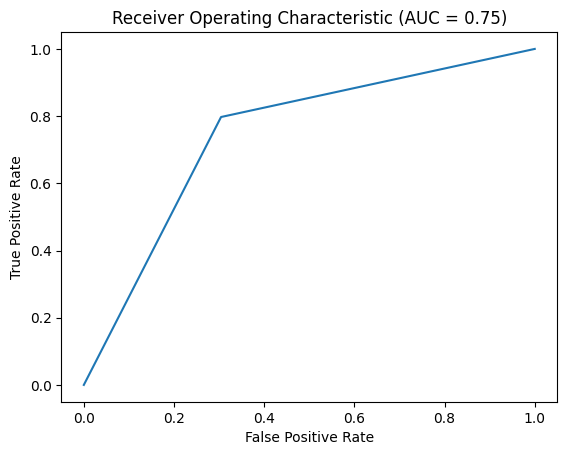

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming you have defined `y_test` and `y_pred` correctly
fpr, tpr, _ = roc_curve(y_test, y_pred_binary)
auc = roc_auc_score(y_test, y_pred_binary)
# Plot ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (AUC = {:.2f})'.format(auc))
plt.show()

Confusion Matrix:
[[192  84]
 [ 46 181]]

Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.70      0.75       276
           1       0.68      0.80      0.74       227

    accuracy                           0.74       503
   macro avg       0.74      0.75      0.74       503
weighted avg       0.75      0.74      0.74       503



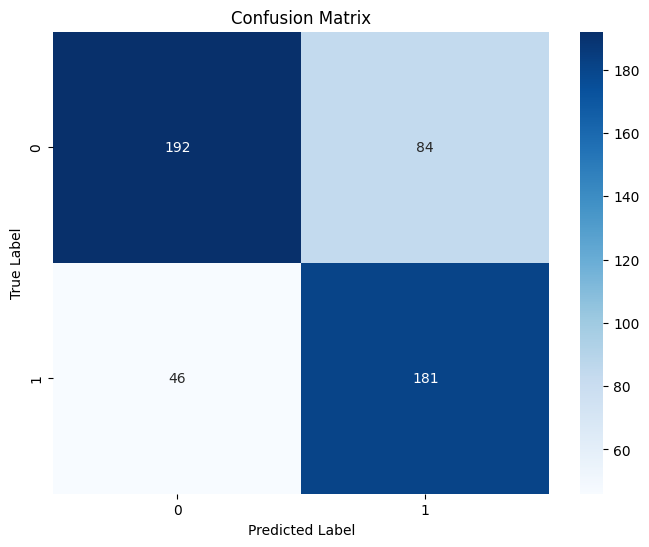

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Convert y_pred to binary values
y_pred_binary = np.round(y_pred).flatten()

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred_binary)

# Generate classification report
report = classification_report(y_test, y_pred_binary)

# Print the confusion matrix and classification report
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

**3.LSTM(Word_2_Vec)**

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import precision_score, f1_score,recall_score
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

# Step 1: Load the dataset
df = pd.read_csv('/content/drive/MyDrive/merge_check.csv')

# Step 2: Preprocess the data
headlines = df['Headline'].values
content = df['Content'].values
labels = df['Label'].values

# Step 3: Tokenize and pad the sequences for Headline and Content separately
tokenizer = Tokenizer()
tokenizer.fit_on_texts(headlines)
headline_sequences = tokenizer.texts_to_sequences(headlines)
headline_sequences = pad_sequences(headline_sequences, padding='post')

tokenizer.fit_on_texts(content)
content_sequences = tokenizer.texts_to_sequences(content)
content_sequences = pad_sequences(content_sequences, padding='post')

# Step 4: Combine the sequences for Headline and Content
X = np.hstack((headline_sequences, content_sequences))

# Step 5: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Step 6: Train Word2Vec model on your dataset
sentences = [text.split() for text in headlines + content]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

oversampler = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Step 8: Calculate class weights
# Step 8: Calculate class weights
class_weights = dict(zip(np.unique(y_train_resampled), [1, 10]))  # Assigning a higher weight to class 1


# Step 9: Build the LSTM model
model = Sequential()
embedding_weights = np.zeros((len(word2vec_model.wv.key_to_index) + 1, 100))
embedding_weights[1:] = word2vec_model.wv.vectors
model.add(Embedding(input_dim=len(word2vec_model.wv.key_to_index) + 1, output_dim=100,
                    weights=[embedding_weights], input_length=X_train_resampled.shape[1], trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 10: Train the LSTM model with the resampled data and class weights
model.fit(X_train_resampled, y_train_resampled, validation_data=(X_test, y_test), epochs=10, batch_size=32, class_weight=class_weights)


# Step 9: Evaluate the LSTM model
loss, accuracy = model.evaluate(X_test, y_test)
print("Accuracy:", accuracy)

# Step 10: Make predictions
predictions = model.predict(X_test)
predictions = np.round(predictions).flatten()

# Step 11: Calculate precision and F1 score
precision = precision_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
recall=recall_score(y_test, predictions)

print("Precision:", precision)
print("F1 Score:", f1)
print("Recall Score:", recall)


Epoch 1/10
86/86 [==============================] - 199s 2s/step - loss: 1.9153 - accuracy: 0.5011 - val_loss: 1.5601 - val_accuracy: 0.4313
Epoch 2/10
86/86 [==============================] - 193s 2s/step - loss: 1.6809 - accuracy: 0.5000 - val_loss: 1.1567 - val_accuracy: 0.4313
Epoch 3/10
86/86 [==============================] - 193s 2s/step - loss: 1.6853 - accuracy: 0.5004 - val_loss: 1.2137 - val_accuracy: 0.4313
Epoch 4/10
86/86 [==============================] - 193s 2s/step - loss: 1.6783 - accuracy: 0.5004 - val_loss: 1.3725 - val_accuracy: 0.4313
Epoch 5/10
86/86 [==============================] - 193s 2s/step - loss: 1.6792 - accuracy: 0.5004 - val_loss: 1.4647 - val_accuracy: 0.4313
Epoch 6/10
86/86 [==============================] - 191s 2s/step - loss: 1.6840 - accuracy: 0.5004 - val_loss: 1.3520 - val_accuracy: 0.4313
Epoch 7/10
86/86 [==============================] - 193s 2s/step - loss: 1.6793 - accuracy: 0.5004 - val_loss: 1.3156 - val_accuracy: 0.4313
Epoch 8/10
86

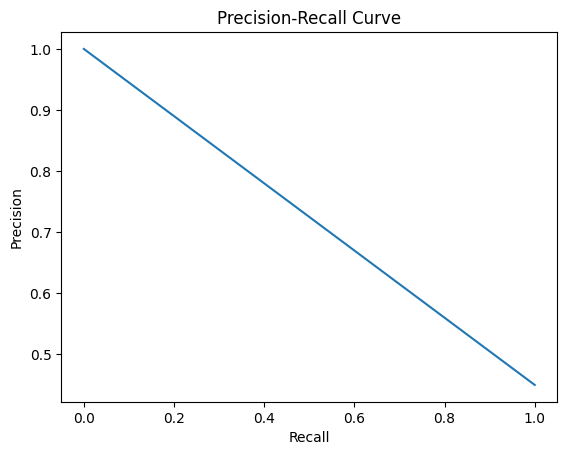

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, predictions)

# Plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

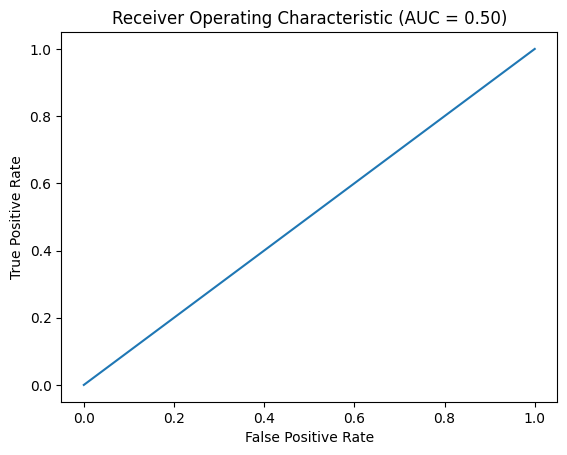

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming you have defined `y_test` and `y_pred` correctly
fpr, tpr, _ = roc_curve(y_test, predictions)
auc = roc_auc_score(y_test, predictions)
# Plot ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (AUC = {:.2f})'.format(auc))
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix:
[[  0 553]
 [  0 452]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       553
           1       0.45      1.00      0.62       452

    accuracy                           0.45      1005
   macro avg       0.22      0.50      0.31      1005
weighted avg       0.20      0.45      0.28      1005



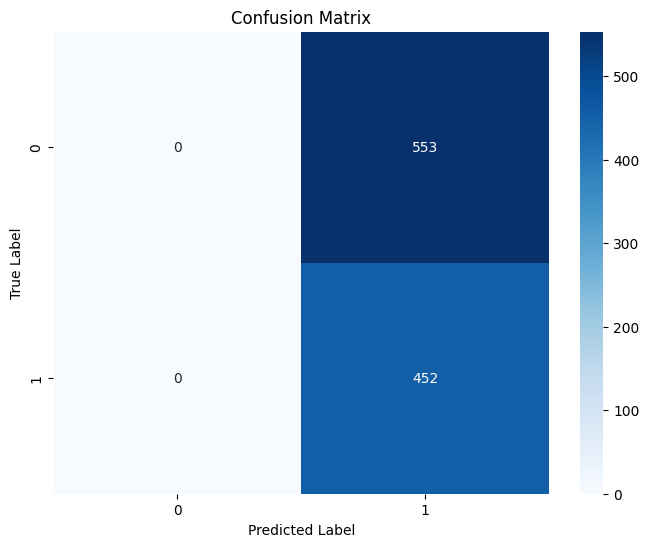

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt



# Generate confusion matrix
cm = confusion_matrix(y_test, predictions)

# Generate classification report
report = classification_report(y_test, predictions)

# Print the confusion matrix and classification report
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
pip install glove_python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.1/263.1 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for glove_python
  Running setup.py clean for glove_python
  error: subprocess-exited-with-error
  
  × python setup.py clean did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed cleaning build dir for glove_python
Failed to build glove_python
ERROR: Could not build wheels for glove_python, which is required to install pyproject.toml-based projects


**4.BiLSTM(Pretrained Glove)**

In [ ]:
!python -m spacy download en_core_web_md

2023-07-15 03:15:12.704341: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 11.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


In [ ]:
import numpy as np
import spacy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import precision_score, f1_score,recall_score
from imblearn.over_sampling import RandomOverSampler

# Step 1: Load the dataset
df = pd.read_csv('/content/drive/MyDrive/merge_check.csv')

# Step 2: Preprocess the data
headlines = df['Headline'].values
content = df['Content'].values
labels = df['Label'].values

# Step 3: Tokenize and pad the sequences for Headline and Content separately
tokenizer = Tokenizer()
tokenizer.fit_on_texts(headlines)
headline_sequences = tokenizer.texts_to_sequences(headlines)
headline_sequences = pad_sequences(headline_sequences, padding='post')

tokenizer.fit_on_texts(content)
content_sequences = tokenizer.texts_to_sequences(content)
content_sequences = pad_sequences(content_sequences, padding='post')

# Step 4: Combine the sequences for Headline and Content
X = np.hstack((headline_sequences, content_sequences))

# Step 5: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Step 6: Perform oversampling on the training data
oversampler = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

# Step 6: Load pre-trained GloVe embeddings with spacy
nlp = spacy.load('en_core_web_md')

# Step 7: Create the embedding matrix
embedding_dim = nlp.vocab.vectors.shape[1]
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if word in nlp.vocab:
        embedding_matrix[index] = nlp.vocab[word].vector

# Step 8: Build the BiLSTM model with pre-trained GloVe embeddings
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
                    input_length=X_train.shape[1], trainable=False))
model.add(Bidirectional(LSTM(128, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 10: Train the BiLSTM model with the resampled data
model.fit(X_train_resampled, y_train_resampled, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# Step 11: Evaluate the BiLSTM model
loss, accuracy = model.evaluate(X_test, y_test)
print("Accuracy:", accuracy)

# Step 12: Make predictions
predictions = model.predict(X_test)
predictions = np.round(predictions).flatten()

# Step 13: Calculate precision and F1 score
precision = precision_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
recall=recall_score(y_test,predictions)

print("Precision:", precision)
print("F1 Score:", f1)
print("Recall Score:", recall)







Epoch 1/10
86/86 [==============================] - 533s 6s/step - loss: 0.6934 - accuracy: 0.4960 - val_loss: 0.6982 - val_accuracy: 0.4313
Epoch 2/10
86/86 [==============================] - 518s 6s/step - loss: 0.6928 - accuracy: 0.5004 - val_loss: 0.6949 - val_accuracy: 0.5672
Epoch 3/10
86/86 [==============================] - 520s 6s/step - loss: 0.6928 - accuracy: 0.4934 - val_loss: 0.6956 - val_accuracy: 0.5672
Epoch 4/10
86/86 [==============================] - 523s 6s/step - loss: 0.6926 - accuracy: 0.4971 - val_loss: 0.6961 - val_accuracy: 0.5672
Epoch 5/10
86/86 [==============================] - 537s 6s/step - loss: 0.6926 - accuracy: 0.4974 - val_loss: 0.6930 - val_accuracy: 0.5672
Epoch 6/10
86/86 [==============================] - 521s 6s/step - loss: 0.6929 - accuracy: 0.4938 - val_loss: 0.6968 - val_accuracy: 0.4299
Epoch 7/10
86/86 [==============================] - 524s 6s/step - loss: 0.6926 - accuracy: 0.4781 - val_loss: 0.6976 - val_accuracy: 0.4313
Epoch 8/10
86

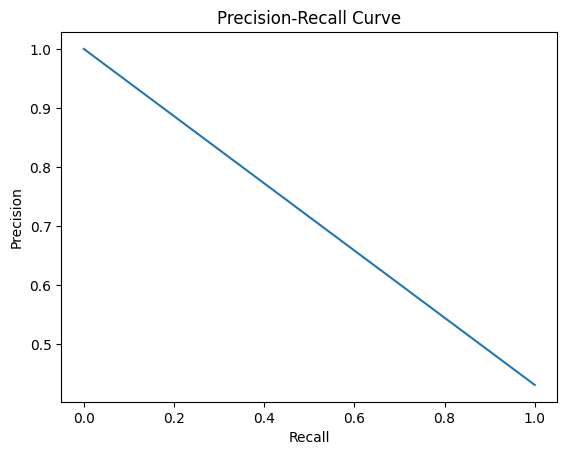

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, predictions)

# Plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

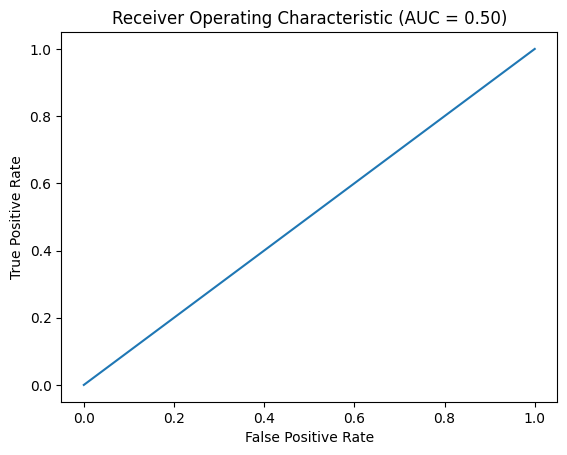

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming you have defined `y_test` and `y_pred` correctly
fpr, tpr, _ = roc_curve(y_test, predictions)
auc = roc_auc_score(y_test, predictions)
# Plot ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (AUC = {:.2f})'.format(auc))
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix:
[[  0 381]
 [  0 289]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       381
           1       0.43      1.00      0.60       289

    accuracy                           0.43       670
   macro avg       0.22      0.50      0.30       670
weighted avg       0.19      0.43      0.26       670



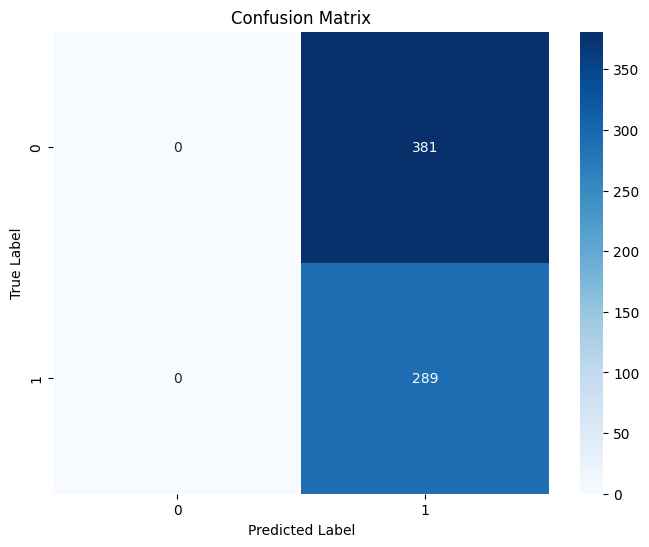

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt



# Generate confusion matrix
cm = confusion_matrix(y_test, predictions)

# Generate classification report
report = classification_report(y_test, predictions)

# Print the confusion matrix and classification report
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

**5.LSTM(Pretrained Glove)**

In [ ]:
import numpy as np
import spacy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import precision_score, f1_score,recall_score

# Step 1: Load the dataset
df = pd.read_csv('/content/drive/MyDrive/merge_check.csv')

# Step 2: Preprocess the data
headlines = df['Headline'].values
content = df['Content'].values
labels = df['Label'].values

# Step 3: Tokenize and pad the sequences for Headline and Content separately
tokenizer = Tokenizer()
tokenizer.fit_on_texts(headlines)
headline_sequences = tokenizer.texts_to_sequences(headlines)
headline_sequences = pad_sequences(headline_sequences, padding='post')

tokenizer.fit_on_texts(content)
content_sequences = tokenizer.texts_to_sequences(content)
content_sequences = pad_sequences(content_sequences, padding='post')

# Step 4: Combine the sequences for Headline and Content
X = np.hstack((headline_sequences, content_sequences))

# Step 5: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.3, random_state=42)

# Step 6: Load pre-trained GloVe embeddings with spaCy
nlp = spacy.load('en_core_web_md')

# Step 7: Create the embedding matrix
embedding_dim = nlp.vocab.vectors.shape[1]
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if word in nlp.vocab:
        embedding_matrix[index] = nlp.vocab[word].vector

# Step 8: Build the LSTM model with pre-trained GloVe embeddings
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
                    input_length=X_train.shape[1], trainable=False))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 9: Train the LSTM model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=32)

# Step 10: Evaluate the LSTM model
loss, accuracy = model.evaluate(X_test, y_test)
print("Accuracy:", accuracy)

# Step 11: Compute F1 score and precision
threshold = 0.5  # Adjusted threshold value
predictions = model.predict(X_test)
predictions = (predictions > threshold).astype(int)  # Apply threshold to convert probabilities to binary predictions
f1 = f1_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall=recall_score(y_test,predictions)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:",recall)

# Step 12: Make predictions
new_df = pd.read_csv('/content/drive/MyDrive/merge_check.csv')  # Load the new dataset
new_headlines = new_df['Headline'].values
new_content = new_df['Content'].values
new_headline_sequences = tokenizer.texts_to_sequences(new_headlines)
new_content_sequences = tokenizer.texts_to_sequences(new_content)
X_new = np.hstack((new_headline_sequences, new_content_sequences))
X_new = pad_sequences(X_new, padding='post', maxlen=X.shape[1])
predictions_new = model.predict(X_new)
predicted_labels = ['Clickbaits' if pred > threshold else 'Non-Clickbaits' for pred in predictions_new]




Epoch 1/15
74/74 [==============================] - 270s 4s/step - loss: 0.6935 - accuracy: 0.5107 - val_loss: 0.6927 - val_accuracy: 0.5502
Epoch 2/15
74/74 [==============================] - 258s 4s/step - loss: 0.6932 - accuracy: 0.5107 - val_loss: 0.6911 - val_accuracy: 0.5502
Epoch 3/15
74/74 [==============================] - 258s 3s/step - loss: 0.6931 - accuracy: 0.5077 - val_loss: 0.6921 - val_accuracy: 0.5502
Epoch 4/15
74/74 [==============================] - 258s 3s/step - loss: 0.6932 - accuracy: 0.5021 - val_loss: 0.6915 - val_accuracy: 0.5502
Epoch 5/15
74/74 [==============================] - 257s 3s/step - loss: 0.6931 - accuracy: 0.5107 - val_loss: 0.6916 - val_accuracy: 0.5502
Epoch 6/15
74/74 [==============================] - 252s 3s/step - loss: 0.6931 - accuracy: 0.5107 - val_loss: 0.6914 - val_accuracy: 0.5502
Epoch 7/15
74/74 [==============================] - 256s 3s/step - loss: 0.6930 - accuracy: 0.5107 - val_loss: 0.6912 - val_accuracy: 0.5502
Epoch 8/15
74

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


210/210 [==============================] - 108s 514ms/step


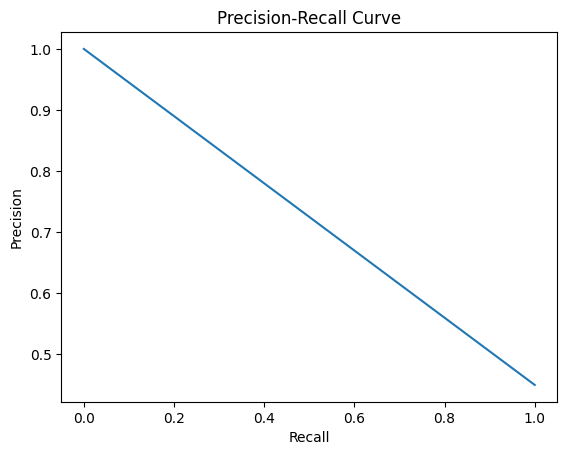

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, predictions)

# Plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

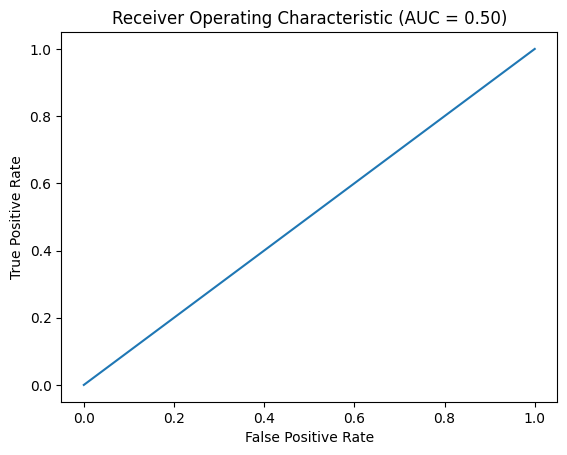

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming you have defined `y_test` and `y_pred` correctly
fpr, tpr, _ = roc_curve(y_test, predictions)
auc = roc_auc_score(y_test, predictions)
# Plot ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (AUC = {:.2f})'.format(auc))
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix:
[[553   0]
 [452   0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.55      1.00      0.71       553
           1       0.00      0.00      0.00       452

    accuracy                           0.55      1005
   macro avg       0.28      0.50      0.35      1005
weighted avg       0.30      0.55      0.39      1005



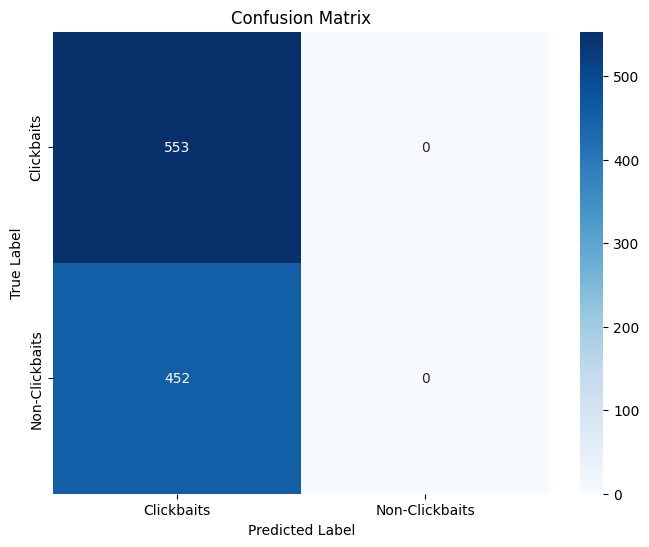

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import itertools



# Generate confusion matrix
cm = confusion_matrix(y_test, predictions)

# Generate classification report
report = classification_report(y_test, predictions)

# Print the confusion matrix and classification report
print("Confusion Matrix:")
print(cm)
print("\nClassification Report:")
print(report)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
ax.tick_params(axis='both', which='major', labelsize=10)  # Adjust to fit
ax.xaxis.set_ticklabels(['Clickbaits', 'Non-Clickbaits']);
ax.yaxis.set_ticklabels(['Clickbaits', 'Non-Clickbaits']);
plt.show()


**6.CNN(Pretrained Glove)**

In [ ]:
import numpy as np
import spacy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import precision_score, f1_score
# Step 1: Load the dataset
df = pd.read_csv('/content/drive/MyDrive/merge_check.csv')

# Step 2: Preprocess the data
headlines = df['Headline'].values
content = df['Content'].values
labels = df['Label'].values

# Step 3: Tokenize and pad the sequences for Headline and Content separately
tokenizer = Tokenizer()
tokenizer.fit_on_texts(headlines)
headline_sequences = tokenizer.texts_to_sequences(headlines)
headline_sequences = pad_sequences(headline_sequences, padding='post')

tokenizer.fit_on_texts(content)
content_sequences = tokenizer.texts_to_sequences(content)
content_sequences = pad_sequences(content_sequences, padding='post')

# Step 4: Combine the sequences for Headline and Content
X = np.hstack((headline_sequences, content_sequences))

# Step 5: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=42)

# Step 6: Load pre-trained GloVe embeddings with spaCy
nlp = spacy.load('en_core_web_md')

# Step 7: Create the embedding matrix
embedding_dim = nlp.vocab.vectors.shape[1]
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if word in nlp.vocab:
        embedding_matrix[index] = nlp.vocab[word].vector

# Step 8: Build the CNN model with pre-trained GloVe embeddings
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
                    input_length=X_train.shape[1], trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 9: Train the CNN model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# Step 10: Evaluate the CNN model
loss, accuracy = model.evaluate(X_test, y_test)
print("Accuracy:", accuracy)

# Step 11: Compute F1 score and precision
threshold = 0.5
predictions = model.predict(X_test)
predictions = (predictions > threshold).astype(int)
f1 = f1_score(y_test, predictions)
precision = precision_score(y_test, predictions)
print("F1 Score:", f1)
print("Precision:", precision)

# Step 12: Make predictions
new_df = pd.read_csv('/content/drive/MyDrive/merge_check.csv')  # Load the new dataset
new_headlines = new_df['Headline'].values
new_content = new_df['Content'].values
new_headline_sequences = tokenizer.texts_to_sequences(new_headlines)
new_content_sequences = tokenizer.texts_to_sequences(new_content)
X_new = np.hstack((new_headline_sequences, new_content_sequences))
X_new = pad_sequences(X_new, padding='post', maxlen=X.shape[1])
predictions_new = model.predict(X_new)

# Assuming predictions are in the range of [0, 1], you can apply a threshold to classify as clickbait or non-clickbait
predicted_labels = ['Clickbaits' if pred > threshold else 'Non-Clickbaits' for pred in predictions_new]

Epoch 1/10
84/84 [==============================] - 54s 631ms/step - loss: 0.8134 - accuracy: 0.4927 - val_loss: 0.8117 - val_accuracy: 0.5687
Epoch 2/10
84/84 [==============================] - 53s 626ms/step - loss: 0.8321 - accuracy: 0.5110 - val_loss: 0.8067 - val_accuracy: 0.5687
Epoch 3/10
84/84 [==============================] - 57s 679ms/step - loss: 0.8002 - accuracy: 0.5114 - val_loss: 0.7909 - val_accuracy: 0.5687
Epoch 4/10
84/84 [==============================] - 57s 687ms/step - loss: 0.7951 - accuracy: 0.5110 - val_loss: 0.9073 - val_accuracy: 0.5701
Epoch 5/10
84/84 [==============================] - 51s 606ms/step - loss: 0.7759 - accuracy: 0.5114 - val_loss: 0.9505 - val_accuracy: 0.5701
Epoch 6/10
84/84 [==============================] - 52s 621ms/step - loss: 0.8717 - accuracy: 0.5114 - val_loss: 0.8537 - val_accuracy: 0.5687
Epoch 7/10
84/84 [==============================] - 51s 607ms/step - loss: 0.8066 - accuracy: 0.5110 - val_loss: 0.7842 - val_accuracy: 0.5582

/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


210/210 [==============================] - 48s 227ms/step


**7.BiLSTM(Pretrained word_2_vec)**

In [ ]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import pandas as pd
from gensim.models import Word2Vec
from sklearn.metrics import precision_score, f1_score,recall_score

# Step 1: Load the dataset
df = pd.read_csv('/content/drive/MyDrive/merge_check.csv')

# Step 2: Preprocess the data
headlines = df['Headline'].values
content = df['Content'].values
labels = df['Label'].values

texts = headlines + ' ' + content

# Step 3: Tokenize the texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Step 4: Pad the sequences
max_sequence_length = max(len(seq) for seq in sequences)
sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Step 5: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)

# Step 6: Load the pre-trained Word2Vec embeddings
word2vec_path = '/content/drive/MyDrive/bnwiki_word2vec.model'
word_vectors = Word2Vec.load(word2vec_path)
word_vectors.syn1neg = np.load('/content/drive/MyDrive/bnwiki_word2vec.model.syn1neg.npy')
word_vectors.wv.vectors = np.load('/content/drive/MyDrive/bnwiki_word2vec.model.wv.vectors.npy')

# Step 7: Create the embedding matrix
embedding_dim = word_vectors.vector_size
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if word in word_vectors.wv:
        embedding_matrix[index] = word_vectors.wv[word]

# Step 8: Build the BiLSTM model with pre-trained Word2Vec embeddings
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
                    input_length=max_sequence_length, trainable=False))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 9: Train the BiLSTM model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# Step 10: Evaluate the BiLSTM model
loss, accuracy = model.evaluate(X_test, y_test)
print("Accuracy:", accuracy)

# Step 11: Make predictions
new_df = pd.read_csv('/content/drive/MyDrive/merge_check.csv')
new_headlines = new_df['Headline'].values
new_content = new_df['Content'].values
new_texts = new_headlines + ' ' + new_content
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_sequences = pad_sequences(new_sequences, maxlen=max_sequence_length)
predictions = model.predict(new_sequences)

# Apply threshold to classify as clickbait or non-clickbait
threshold = 0.5

# Convert numeric labels to strings
labels = ['Clickbaits' if label == 1 else 'Non-Clickbaits' for label in labels]
predicted_labels = ['Clickbaits' if pred > threshold else 'Non-Clickbaits' for pred in predictions]

# Calculate precision and F1 score
precision = precision_score(labels, predicted_labels, pos_label='Clickbaits')
f1 = f1_score(labels, predicted_labels, pos_label='Clickbaits')
recall = recall_score(labels, predicted_labels, pos_label='Clickbaits')

print("Precision:", precision)
print("F1 Score:", f1)
print("Recall Score:", recall)


Epoch 1/10
84/84 [==============================] - 279s 3s/step - loss: 0.3752 - accuracy: 0.8544 - val_loss: 0.2567 - val_accuracy: 0.9209
Epoch 2/10
84/84 [==============================] - 237s 3s/step - loss: 0.2765 - accuracy: 0.9074 - val_loss: 0.3057 - val_accuracy: 0.9000
Epoch 3/10
84/84 [==============================] - 239s 3s/step - loss: 0.2681 - accuracy: 0.9074 - val_loss: 0.2596 - val_accuracy: 0.9269
Epoch 4/10
84/84 [==============================] - 234s 3s/step - loss: 0.2479 - accuracy: 0.9145 - val_loss: 0.2453 - val_accuracy: 0.9299
Epoch 5/10
84/84 [==============================] - 235s 3s/step - loss: 0.2057 - accuracy: 0.9276 - val_loss: 0.2850 - val_accuracy: 0.9104
Epoch 6/10
84/84 [==============================] - 235s 3s/step - loss: 0.1920 - accuracy: 0.9317 - val_loss: 0.2668 - val_accuracy: 0.9075
Epoch 7/10
84/84 [==============================] - 235s 3s/step - loss: 0.1408 - accuracy: 0.9496 - val_loss: 0.2677 - val_accuracy: 0.9194
Epoch 8/10
84

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Step 17: Calculate precision and recall
precision, recall, _ = precision_recall_curve(y_test, predictions, pos_label='Clickbaits')

# Step 18: Plot the precision-recall curve
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

ValueError: ignored

**8.CNN(Pretrained Word_2_Vec)**




In [ ]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import pandas as pd
from gensim.models import Word2Vec
from sklearn.metrics import precision_score, f1_score,recall_score

# Step 1: Load the dataset
df = pd.read_csv('/content/drive/MyDrive/merge_check.csv')

# Step 2: Preprocess the data
headlines = df['Headline'].values
content = df['Content'].values
labels = df['Label'].values

texts = headlines + ' ' + content

# Step 3: Tokenize the texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Step 4: Pad the sequences
max_sequence_length = max(len(seq) for seq in sequences)
sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Step 5: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)

# Step 6: Load the pre-trained Word2Vec embeddings
word2vec_path = '/content/drive/MyDrive/bnwiki_word2vec.model'
word_vectors = Word2Vec.load(word2vec_path)
word_vectors.syn1neg = np.load('/content/drive/MyDrive/bnwiki_word2vec.model.syn1neg.npy')
word_vectors.wv.vectors = np.load('/content/drive/MyDrive/bnwiki_word2vec.model.wv.vectors.npy')

# Step 7: Create the embedding matrix
embedding_dim = word_vectors.vector_size
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if word in word_vectors.wv:
        embedding_matrix[index] = word_vectors.wv[word]

# Step 8: Build the CNN model with pre-trained Word2Vec embeddings
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
                    input_length=max_sequence_length, trainable=False))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 9: Train the CNN model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# Step 10: Evaluate the CNN model
loss, accuracy = model.evaluate(X_test, y_test)
print("Accuracy:", accuracy)

# Step 9: Make predictions
new_df = pd.read_csv('/content/drive/MyDrive/merge_check.csv')
new_headlines = new_df['Headline'].values
new_content = new_df['Content'].values
new_texts = new_headlines + ' ' + new_content
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_sequences = pad_sequences(new_sequences, maxlen=max_sequence_length)
predictions = model.predict(new_sequences)

# Step 10: Apply threshold and convert predictions to labels
threshold = 0.5
labels = ['Clickbaits' if label == 1 else 'Non-Clickbaits' for label in labels]
predicted_labels = ['Clickbaits' if pred > threshold else 'Non-Clickbaits' for pred in predictions]

# Step 11: Calculate precision and F1 score
precision = precision_score(labels, predicted_labels, pos_label='Clickbaits')
f1 = f1_score(labels, predicted_labels, pos_label='Clickbaits')
recall = recall_score(labels, predicted_labels, pos_label='Clickbaits')

print("Precision:", precision)
print("F1 Score:", f1)
print("Recall:", recall)

Epoch 1/10
84/84 [==============================] - 20s 219ms/step - loss: 0.3198 - accuracy: 0.8701 - val_loss: 0.2446 - val_accuracy: 0.9075
Epoch 2/10
84/84 [==============================] - 17s 205ms/step - loss: 0.0855 - accuracy: 0.9761 - val_loss: 0.2543 - val_accuracy: 0.9134
Epoch 3/10
84/84 [==============================] - 17s 206ms/step - loss: 0.0323 - accuracy: 0.9985 - val_loss: 0.2644 - val_accuracy: 0.9149
Epoch 4/10
84/84 [==============================] - 18s 214ms/step - loss: 0.0170 - accuracy: 1.0000 - val_loss: 0.2456 - val_accuracy: 0.9254
Epoch 5/10
84/84 [==============================] - 19s 221ms/step - loss: 0.0108 - accuracy: 1.0000 - val_loss: 0.2482 - val_accuracy: 0.9284
Epoch 6/10
84/84 [==============================] - 17s 207ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.2515 - val_accuracy: 0.9299
Epoch 7/10
84/84 [==============================] - 17s 207ms/step - loss: 0.0064 - accuracy: 1.0000 - val_loss: 0.2639 - val_accuracy: 0.9224

**9.LSTM(Pretrained Word_2_Vec)**

In [ ]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import pandas as pd
from gensim.models import Word2Vec
from sklearn.metrics import precision_score, recall_score, f1_score

# Step 1: Load the dataset
df = pd.read_csv('/content/drive/MyDrive/merge_check.csv')

# Step 2: Preprocess the data
headlines = df['Headline'].values
content = df['Content'].values
labels = df['Label'].values

texts = headlines + ' ' + content

# Step 3: Tokenize the texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Step 4: Pad the sequences
max_sequence_length = max(len(seq) for seq in sequences)
sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Step 5: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)

# Step 6: Load the pre-trained Word2Vec embeddings
word2vec_path = '/content/drive/MyDrive/bnwiki_word2vec.model'
word_vectors = Word2Vec.load(word2vec_path)
word_vectors.syn1neg = np.load('/content/drive/MyDrive/bnwiki_word2vec.model.syn1neg.npy')
word_vectors.wv.vectors = np.load('/content/drive/MyDrive/bnwiki_word2vec.model.wv.vectors.npy')

# Step 7: Create the embedding matrix
embedding_dim = word_vectors.vector_size
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if word in word_vectors.wv:
        embedding_matrix[index] = word_vectors.wv[word]

# Step 8: Build the LSTM model with pre-trained Word2Vec embeddings
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
                    input_length=max_sequence_length, trainable=False))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 9: Train the LSTM model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# Step 10: Evaluate the LSTM model
loss, accuracy = model.evaluate(X_test, y_test)
print("Accuracy:", accuracy)
# Step 9: Make predictions
new_df = pd.read_csv('/content/drive/MyDrive/merge_check.csv')
new_headlines = new_df['Headline'].values
new_content = new_df['Content'].values
new_texts = new_headlines + ' ' + new_content
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_sequences = pad_sequences(new_sequences, maxlen=max_sequence_length)
predictions = model.predict(new_sequences)


# Step 12: Convert the predicted probabilities to binary labels
predicted_labels = (predictions > 0.5).astype(int)

# Step 13: Calculate precision, recall, and F1 score
precision = precision_score(labels, predicted_labels)
recall = recall_score(labels, predicted_labels)
f1 = f1_score(labels, predicted_labels)

# Step 14: Print the evaluation metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Epoch 1/10
84/84 [==============================] - 123s 1s/step - loss: 0.3831 - accuracy: 0.8414 - val_loss: 0.2652 - val_accuracy: 0.9119
Epoch 2/10
84/84 [==============================] - 123s 1s/step - loss: 0.4126 - accuracy: 0.8313 - val_loss: 0.2804 - val_accuracy: 0.9015
Epoch 3/10
84/84 [==============================] - 132s 2s/step - loss: 0.2658 - accuracy: 0.9074 - val_loss: 0.2457 - val_accuracy: 0.9209
Epoch 4/10
84/84 [==============================] - 122s 1s/step - loss: 0.2358 - accuracy: 0.9179 - val_loss: 0.2303 - val_accuracy: 0.9224
Epoch 5/10
84/84 [==============================] - 131s 2s/step - loss: 0.2015 - accuracy: 0.9261 - val_loss: 0.2270 - val_accuracy: 0.9269
Epoch 6/10
84/84 [==============================] - 122s 1s/step - loss: 0.1648 - accuracy: 0.9414 - val_loss: 0.2430 - val_accuracy: 0.9119
Epoch 7/10
84/84 [==============================] - 130s 2s/step - loss: 0.1409 - accuracy: 0.9548 - val_loss: 0.2436 - val_accuracy: 0.9209
Epoch 8/10
84

21/21 [==============================] - 14s 645ms/step


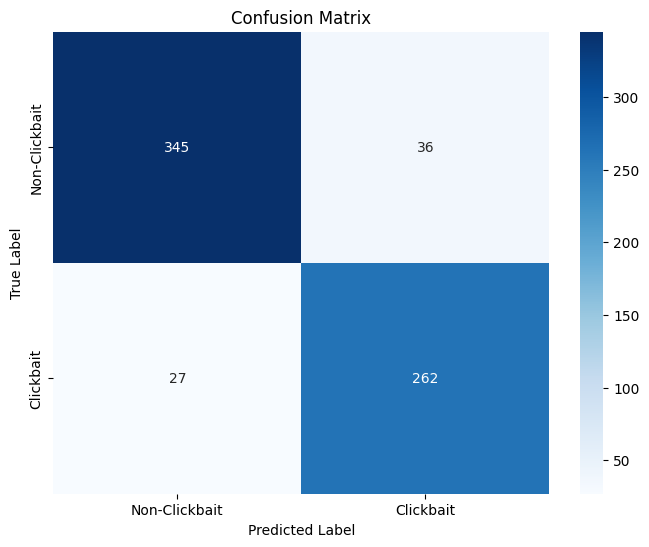

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       381
           1       0.88      0.91      0.89       289

    accuracy                           0.91       670
   macro avg       0.90      0.91      0.90       670
weighted avg       0.91      0.91      0.91       670



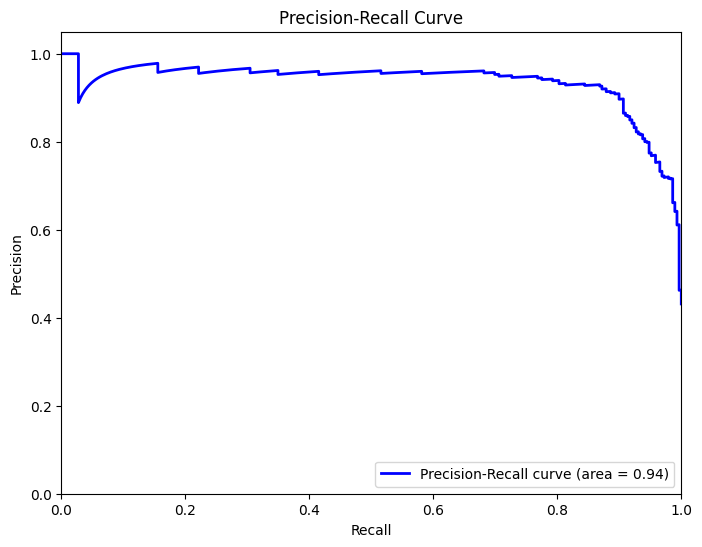

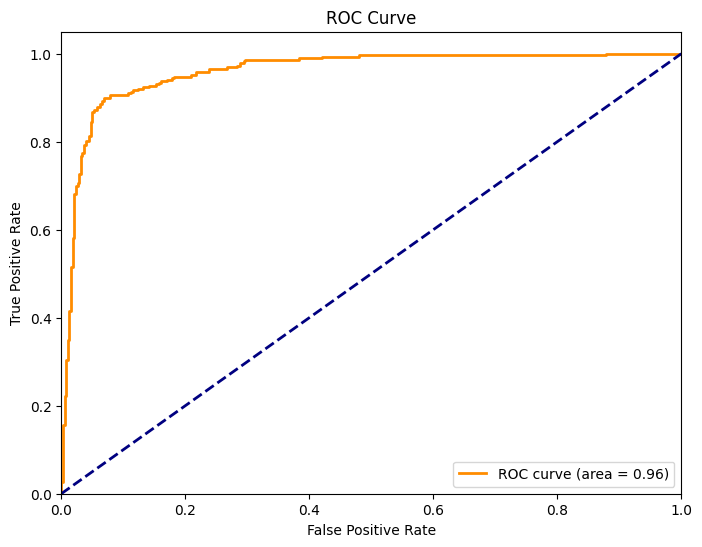

In [ ]:
import os
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import pandas as pd
from gensim.models import Word2Vec
from sklearn.metrics import precision_recall_curve, roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Step 10: Evaluate the LSTM model
y_pred_probs = model.predict(X_test)

# Step 11: Generate precision-recall curve and ROC curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_probs)
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Step 12: Generate confusion matrix
y_pred_labels = (y_pred_probs > 0.5).astype(int)
conf_matrix = confusion_matrix(y_test, y_pred_labels)

# Step 13: Plot confusion matrix with heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Clickbait', 'Clickbait'], yticklabels=['Non-Clickbait', 'Clickbait'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Step 14: Generate and print classification report
print("Classification Report:")
print(classification_report(y_test, y_pred_labels))

# Step 15: Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2, label='Precision-Recall curve (area = %0.2f)' % auc(recall, precision))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.show()

# Step 16: Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

**10.BiLSTM(Glove)**

In [ ]:
import os
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import precision_score, recall_score, f1_score

def train_glove(texts, embedding_dim, window_size=10, learning_rate=0.05, epochs=100):
    vectorizer = CountVectorizer(tokenizer=lambda text: text.split(), lowercase=False)
    co_occurrences = vectorizer.fit_transform(texts)

    # Reduce the dimensionality of the co-occurrences matrix using TruncatedSVD
    svd = TruncatedSVD(n_components=embedding_dim)
    co_occurrences_reduced = svd.fit_transform(co_occurrences)

    # Perform SVD on the reduced matrix
    U, _, _ = np.linalg.svd(co_occurrences_reduced)

    # Retrieve the word embeddings from the SVD results
    embedding_matrix = U[:, :embedding_dim]

    # Create a dictionary mapping words to their corresponding embedding vectors
    vocabulary = vectorizer.vocabulary_
    word_embeddings = {word: embedding for word, embedding in zip(vocabulary, embedding_matrix)}

    return word_embeddings

# Step 1: Load the dataset from CSV
df = pd.read_csv('/content/drive/MyDrive/merge_check.csv')
headlines = df['Headline'].values
content = df['Content'].values
labels = df['Label'].values
texts = headlines + ' ' + content

# Step 2: Train the GloVe embeddings
embedding_dim = 100  # Set the desired embedding dimension
word_embeddings = train_glove(texts, embedding_dim)

# Step 3: Preprocess the data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
max_sequence_length = max(len(seq) for seq in sequences)
sequences = pad_sequences(sequences, maxlen=max_sequence_length)
vocab_size = len(tokenizer.word_index) + 1

# Step 4: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.2, random_state=42)

# Step 5: Create the embedding matrix
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if word in word_embeddings:
        embedding_matrix[index] = word_embeddings[word]

# Step 6: Build the BiLSTM model with GloVe embeddings
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
                    input_length=max_sequence_length, trainable=False))
model.add(Bidirectional(LSTM(128)))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 7: Train the BiLSTM model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# Step 8: Evaluate the BiLSTM model
loss, accuracy = model.evaluate(X_test, y_test)
print("Accuracy:", accuracy)

# Step 9: Make predictions on the test set
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)

# Step 10: Calculate precision, recall, and F1 score
precision = precision_score(y_test, predicted_labels)
recall = recall_score(y_test, predicted_labels)
f1 = f1_score(y_test, predicted_labels)

# Step 11: Print the evaluation metrics
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Epoch 1/10
84/84 [==============================] - 272s 3s/step - loss: 0.6947 - accuracy: 0.5607 - val_loss: 0.6889 - val_accuracy: 0.6597
Epoch 2/10
84/84 [==============================] - 243s 3s/step - loss: 0.6791 - accuracy: 0.6271 - val_loss: 0.6195 - val_accuracy: 0.6343
Epoch 3/10
84/84 [==============================] - 249s 3s/step - loss: 0.6988 - accuracy: 0.5857 - val_loss: 0.6487 - val_accuracy: 0.5851
Epoch 4/10
84/84 [==============================] - 249s 3s/step - loss: 0.6760 - accuracy: 0.6372 - val_loss: 0.7288 - val_accuracy: 0.4313
Epoch 5/10
84/84 [==============================] - 248s 3s/step - loss: 0.6978 - accuracy: 0.5121 - val_loss: 0.6796 - val_accuracy: 0.5687
Epoch 6/10
84/84 [==============================] - 268s 3s/step - loss: 0.6906 - accuracy: 0.5222 - val_loss: 0.6895 - val_accuracy: 0.5239
Epoch 7/10
84/84 [==============================] - 249s 3s/step - loss: 0.6879 - accuracy: 0.5416 - val_loss: 0.6791 - val_accuracy: 0.6000
Epoch 8/10
84

In [ ]:
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

# Load the CSV file
data = pd.read_csv("/content/drive/MyDrive/merge_check.csv")

# Extract the text and label columns from the CSV
texts = data["Headline"] + " " + data["Content"]
labels = data["Label"].tolist()

# Initialize the tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

# Preprocess your text data and convert it to sequences
sequences = tokenizer.texts_to_sequences(texts)

# Train Word2Vec model on your preprocessed text data
sentences = [text.split() for text in texts]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Convert each word to its corresponding word vector
embedding_matrix = np.zeros((len(word2vec_model.wv.key_to_index) + 1, 100))
for word, index in word2vec_model.wv.key_to_index.items():
    embedding_matrix[index] = word2vec_model.wv.get_vector(word)

# Convert text sequences to padded sequences
max_sequence_length = max([len(seq) for seq in sequences])
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Split the data into training, validation, and test sets
X_train, X_val_test, y_train, y_val_test = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val_test, y_val_test, test_size=0.5, random_state=42)

# Convert labels to NumPy arrays
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Define the CNN model
cnn_model = Sequential()
cnn_model.add(Embedding(len(word2vec_model.wv.key_to_index) + 1, 100, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
cnn_model.add(Conv1D(128, 5, activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

# Compile the CNN model
cnn_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the CNN model
cnn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=64)

# Define the LSTM model
lstm_model = Sequential()
embedding_weights = np.zeros((len(word2vec_model.wv.key_to_index) + 1, 100))
embedding_weights[1:] = word2vec_model.wv.vectors
lstm_model.add(Embedding(input_dim=len(word2vec_model.wv.key_to_index) + 1, output_dim=100,
                         weights=[embedding_weights], input_length=max_sequence_length, trainable=False))
lstm_model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile the LSTM model
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the LSTM model
lstm_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

# Evaluate the models
cnn_loss, cnn_accuracy = cnn_model.evaluate(X_test, y_test)
print("CNN Accuracy:", cnn_accuracy)

lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test, y_test)
print("LSTM Accuracy:", lstm_accuracy)

# Make predictions using the models
cnn_predictions = cnn_model.predict(X_test)
lstm_predictions = lstm_model.predict(X_test)

# Weighted averaging ensemble
cnn_weight = 0.5  # Weight for the CNN model
lstm_weight = 0.5  # Weight for the LSTM model

ensemble_predictions = cnn_weight * cnn_predictions + lstm_weight * lstm_predictions
ensemble_predictions = np.where(ensemble_predictions > 0.5, 1, 0)

ensemble_accuracy = np.sum(ensemble_predictions.flatten() == y_test) / len(y_test)
print("Ensemble Accuracy:", ensemble_accuracy)



Epoch 1/10
42/42 [==============================] - 12s 272ms/step - loss: 0.7186 - accuracy: 0.5551 - val_loss: 0.6659 - val_accuracy: 0.5970
Epoch 2/10
42/42 [==============================] - 11s 270ms/step - loss: 0.6326 - accuracy: 0.6398 - val_loss: 0.6967 - val_accuracy: 0.5552
Epoch 3/10
42/42 [==============================] - 11s 272ms/step - loss: 0.5939 - accuracy: 0.6831 - val_loss: 0.6101 - val_accuracy: 0.6478
Epoch 4/10
42/42 [==============================] - 11s 269ms/step - loss: 0.5614 - accuracy: 0.6999 - val_loss: 0.5614 - val_accuracy: 0.6716
Epoch 5/10
42/42 [==============================] - 11s 269ms/step - loss: 0.5431 - accuracy: 0.7092 - val_loss: 0.5318 - val_accuracy: 0.6985
Epoch 6/10
42/42 [==============================] - 11s 251ms/step - loss: 0.5241 - accuracy: 0.7256 - val_loss: 0.6157 - val_accuracy: 0.6388
Epoch 7/10
42/42 [==============================] - 11s 259ms/step - loss: 0.5109 - accuracy: 0.7376 - val_loss: 0.5000 - val_accuracy: 0.7284

In [ ]:
pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.8/68.8 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Using cached pybind11-2.10.4-py3-none-any.whl (222 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp310-cp310-linux_x86_64.whl size=4393420 sha256=8a80b799a2ab1c6d4b3210567560875dc73c0dba87ad49cfb628176ab92fa8b0
  Stored in directory: /root/.cache/pip/wheels/a5/13/75/f811c84a8ab36eedbaef977a6a58a98990e8e0f1967f98f394
Successfully built fasttext


In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, LSTM
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import pandas as pd
import fasttext
from sklearn.metrics import precision_score, f1_score,accuracy_score,recall_score

# Step 1: Load the dataset
df = pd.read_csv('/content/drive/MyDrive/merge_check.csv')

# Step 2: Preprocess the data
headlines = df['Headline'].values
content = df['Content'].values
labels = df['Label'].values

texts = headlines + ' ' + content

# Step 3: Tokenize the texts
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Step 4: Pad the sequences
max_sequence_length = max(len(seq) for seq in sequences)
sequences = pad_sequences(sequences, maxlen=max_sequence_length)



# Step 5: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(sequences, labels, test_size=0.3, random_state=42)

# Step 6: Create the corpus file
corpus_file = 'corpus.txt'
with open(corpus_file, 'w') as file:
    for headline, content in zip(headlines, content):
        file.write(headline + ' ' + content + '\n')

# Step 7: Train FastText embeddings
model1 = fasttext.train_unsupervised(corpus_file, dim=300)

# Step 8: Create the embedding matrix for model1
embedding_dim = 300
vocab_size = len(tokenizer.word_index) + 1

embedding_matrix1 = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if word in model1:
        embedding_matrix1[index] = model1[word]

# Step 9: Build the BiLSTM model with FastText embeddings (model1)
model1 = Sequential()
model1.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix1],
                     input_length=X_train.shape[1], trainable=False))
model1.add(Bidirectional(LSTM(128)))
model1.add(Dense(1, activation='sigmoid'))

model1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 10: Train the BiLSTM model (model1)
model1.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# Step 11: Evaluate the BiLSTM model (model1)
loss, accuracy = model1.evaluate(X_test, y_test)
print("Model 1 Accuracy:", accuracy)

# Step 12: Make predictions using model1
predictions1 = model1.predict(X_test)

# Step 13: Train and evaluate model2 (CNN)
# ... (code for model2 - CNN)

# Step 6: Load the pre-trained Word2Vec embeddings
word2vec_path = '/content/drive/MyDrive/bnwiki_word2vec.model'
word_vectors = Word2Vec.load(word2vec_path)
word_vectors.syn1neg = np.load('/content/drive/MyDrive/bnwiki_word2vec.model.syn1neg.npy')
word_vectors.wv.vectors = np.load('/content/drive/MyDrive/bnwiki_word2vec.model.wv.vectors.npy')

# Step 7: Create the embedding matrix
embedding_dim = word_vectors.vector_size
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, index in tokenizer.word_index.items():
    if word in word_vectors.wv:
        embedding_matrix[index] = word_vectors.wv[word]


model2 = Sequential()
model2.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
                    input_length=max_sequence_length, trainable=False))
model2.add(Conv1D(128, 5, activation='relu'))
model2.add(GlobalMaxPooling1D())
model2.add(Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 9: Train the CNN model
model2.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# Step 10: Evaluate the CNN model
loss, accuracy = model2.evaluate(X_test, y_test)
print("Model2 Accuracy:", accuracy)



# Step 14: Make predictions using model2 (CNN)
# ... (code for predicting using model2 - CNN)
# Step 9: Make predictions
#new_df = pd.read_csv('/content/drive/MyDrive/merge_check.csv')
#new_headlines = new_df['Headline'].values
#new_content = new_df['Content'].values
#new_texts = new_headlines + ' ' + new_content
#new_sequences = tokenizer.texts_to_sequences(new_texts)
#new_sequences = pad_sequences(new_sequences, maxlen=max_sequence_length)
predictions2 = model2.predict(X_test)

# Step 15: Train and evaluate model3 (LSTM)
# ... (code for model3 - LSTM)
model3 = Sequential()
model3.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
                    input_length=max_sequence_length, trainable=False))
model3.add(LSTM(128))
model3.add(Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 9: Train the LSTM model
model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# Step 10: Evaluate the LSTM model
loss, accuracy = model3.evaluate(X_test, y_test)
print("Model3 Accuracy:", accuracy)


# Step 16: Make predictions using model3 (LSTM)
# ... (code for predicting using model3 - LSTM)
# Step 9: Make predictions
#new_df = pd.read_csv('/content/drive/MyDrive/merge_check.csv')
#new_headlines = new_df['Headline'].values
#new_content = new_df['Content'].values
#new_texts = new_headlines + ' ' + new_content
#new_sequences = tokenizer.texts_to_sequences(new_texts)
#new_sequences = pad_sequences(new_sequences, maxlen=max_sequence_length)
#predictions3 = model3.predict(new_sequences)
predictions3 = model3.predict(X_test)


# Step 17: Train and evaluate model4 (CNN)
# ... (code for model4 - CNN)
#model4 = fasttext.train_unsupervised(corpus_file, dim=300)

# Step 8: Build the CNN model with FastText embeddings
#embedding_dim = 300
#vocab_size = len(tokenizer.word_index) + 1

#model4 = Sequential()
#model4.add(Embedding(vocab_size, embedding_dim, input_length=X_train.shape[1]))
#model4.add(Conv1D(128, 5, activation='relu'))
#model4.add(GlobalMaxPooling1D())
#model4.add(Dense(1, activation='sigmoid'))

#model4.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 9: Train the CNN model
#model4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=10, batch_size=32)

# Step 10: Evaluate the CNN model
#loss, accuracy = model4.evaluate(X_test, y_test)
#print("Model4 Accuracy:", accuracy)


# Step 18: Make predictions using model4 (CNN)
# ... (code for predicting using model4 - CNN)
# Step 11: Make predictions
#predictions4 = model4.predict(X_test)
#predictions4 = np.round(predictions4).flatten()

weights = [0.4, 0.3, 0.3]  # Weights for each model's predictions

# Step 10: Combine predictions from all models using weighted averaging
ensemble_predictions = (weights[0] * predictions1 + weights[1] * predictions2 +
                        weights[2] * predictions3 ) / np.sum(weights)
ensemble_predictions = np.round(ensemble_predictions).flatten().astype(int)

# Step 11: Reshape ensemble predictions to match the shape of y_test
ensemble_predictions = ensemble_predictions[:y_test.shape[0]]

# Step 12: Calculate ensemble metrics
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
ensemble_precision = precision_score(y_test, ensemble_predictions)
ensemble_f1 = f1_score(y_test, ensemble_predictions)
ensemble_recall = recall_score(y_test, ensemble_predictions)

# Step 13: Print ensemble metrics
print("Ensemble Accuracy:", ensemble_accuracy)
print("Ensemble Precision:", ensemble_precision)
print("Ensemble F1 Score:", ensemble_f1)
print("Ensemble Recall:", ensemble_recall)

Epoch 1/10
74/74 [==============================] - 300s 4s/step - loss: 0.3926 - accuracy: 0.8575 - val_loss: 0.3158 - val_accuracy: 0.8876
Epoch 2/10
74/74 [==============================] - 284s 4s/step - loss: 0.2904 - accuracy: 0.9006 - val_loss: 0.3032 - val_accuracy: 0.9075
Epoch 3/10
74/74 [==============================] - 289s 4s/step - loss: 0.2817 - accuracy: 0.9074 - val_loss: 0.2806 - val_accuracy: 0.8945
Epoch 4/10
74/74 [==============================] - 287s 4s/step - loss: 0.3759 - accuracy: 0.8349 - val_loss: 0.3305 - val_accuracy: 0.8905
Epoch 5/10
74/74 [==============================] - 284s 4s/step - loss: 0.3215 - accuracy: 0.8776 - val_loss: 0.2724 - val_accuracy: 0.9174
Epoch 6/10
74/74 [==============================] - 283s 4s/step - loss: 0.2899 - accuracy: 0.8865 - val_loss: 0.2626 - val_accuracy: 0.8876
Epoch 7/10
74/74 [==============================] - 290s 4s/step - loss: 0.3716 - accuracy: 0.8494 - val_loss: 0.5491 - val_accuracy: 0.8010
Epoch 8/10
74

##Data Statistics(Headline)

In [ ]:
data_path = "/content/drive/MyDrive/merge_check.csv"
data = pd.read_csv(data_path)

print("Size of the total data==> ", len(data))
class_names= data.F_type.unique() ## Get the unique values in a specific column
print(class_names)

Size of the total data==>  3349
['Clickbaits' 'Non-Clickbaits']


In [ ]:
def data_statistics(class_names):
  words_per_class = []
  unique_words_per_class = []
  documents_per_class = []

  for label in class_names:
    ## Word list from the clean dataset
    word_list = [word.strip().lower() for t in list(data[data.F_type==label].Headline) for word in t.strip().split()]
    counts = dict()
    for w in word_list:
      counts[w] = counts.get(w, 0)+1
    # Sort the word list on descending order in terms of frequency
    ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
    # Total words per class
    words_per_class.append(len(word_list))
    # Unique words per class
    unique_words_per_class.append(len(np.unique(word_list)))
    # Number of documents per class
    documents_per_class.append(len(list(data[data.F_type==label].Headline)))

    print("Class name: {}".format(label))
    print("Number of words: {}".format(len(word_list)))
    print("Number of unique words: {}".format(len(np.unique(word_list))))
    print("Number of Documents: {}".format(len(list(data[data.F_type==label].Headline))))
    print("10 most frequent words:\n")
    for i, f in ordered[:10]:
      print("{}\t{}".format(i, f))

  return words_per_class, unique_words_per_class, documents_per_class

# Define your class names
class_names = ['Clickbaits', 'Non-Clickbaits']

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/merge_check.csv')

words, unique_words, documents = data_statistics(class_names)






Class name: Clickbaits
Number of words: 14906
Number of unique words: 5285
Number of Documents: 1750
10 most frequent words:

এই	222
যা	143
না	115
সঙ্গে	112
ভিডিও	103
ভাইরাল	102
কি	93
:	90
করতে	81
করে	81
Class name: Non-Clickbaits
Number of words: 10647
Number of unique words: 4728
Number of Documents: 1599
10 most frequent words:

২০১৮	72
সেপ্টেম্বর,	69
১৯	66
না	63
প্রধানমন্ত্রী	60
ও	53
থেকে	44
নিয়ে	42
পাকিস্তান	41
:	33


In [ ]:
data_matrix = pd.DataFrame({'Total Documents':documents,
                            'Total Words':words,
                            'Unique Words':unique_words,
                            'Class Names':class_names})
data_matrix

,Total Documents,Total Words,Unique Words,Class Names
0,1750,14906,5285,Clickbaits
1,1599,10647,4728,Non-Clickbaits


In [ ]:
frequency = dict()
for x in data['Headline']:
  i = len(x.split())
  frequency[i] = frequency.get(i, 0)+1
frequency = sorted(frequency.items(), key= lambda item: item[0])
print(frequency)
print(type(frequency))

[(2, 8), (3, 58), (4, 202), (5, 384), (6, 541), (7, 550), (8, 505), (9, 425), (10, 277), (11, 184), (12, 109), (13, 48), (14, 30), (15, 6), (16, 4), (17, 4), (18, 4), (19, 4), (21, 1), (23, 1), (26, 1), (27, 1), (30, 1), (31, 1)]
<class 'list'>


Length frequency ditribution

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 21, 23, 26, 27, 30, 31] [8, 58, 202, 384, 541, 550, 505, 425, 277, 184, 109, 48, 30, 6, 4, 4, 4, 4, 1, 1, 1, 1, 1, 1]


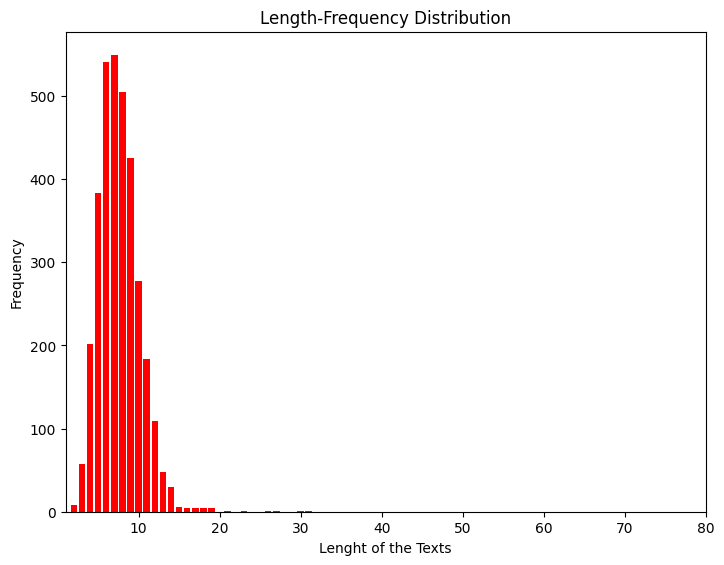

In [ ]:
import matplotlib.pyplot as plt

xx = [x for x, k in frequency]
yy = [k for x, k in frequency]
print(xx, yy)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(xx,yy, color='r')
plt.xlim(1, 80)



plt.xlabel('Lenght of the Texts')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()

##Data Statistics(Content)

In [ ]:
def data_statistics(class_names):
  words_per_class = []
  unique_words_per_class = []
  documents_per_class = []

  for label in class_names:
    ## Word list from the clean dataset
    word_list = [word.strip().lower() for t in list(data[data.F_type==label].Content) for word in t.strip().split()]
    counts = dict()
    for w in word_list:
      counts[w] = counts.get(w, 0)+1
    # Sort the word list on descending order in terms of frequency
    ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
    # Total words per class
    words_per_class.append(len(word_list))
    # Unique words per class
    unique_words_per_class.append(len(np.unique(word_list)))
    # Number of documents per class
    documents_per_class.append(len(list(data[data.F_type==label].Content)))

    print("Class name: {}".format(label))
    print("Number of words: {}".format(len(word_list)))
    print("Number of unique words: {}".format(len(np.unique(word_list))))
    print("Number of Documents: {}".format(len(list(data[data.F_type==label].Content))))
    print("10 most frequent words:\n")
    for i, f in ordered[:10]:
      print("{}\t{}".format(i, f))

  return words_per_class, unique_words_per_class, documents_per_class

# Define your class names
class_names = ['Clickbaits', 'Non-Clickbaits']

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/merge_check.csv')

words1, unique_words1, documents1 = data_statistics(class_names)

Class name: Clickbaits
Number of words: 145810
Number of unique words: 27522
Number of Documents: 1750
10 most frequent words:

এই	1659
তার	1089
করে	1037
ও	773
একটি	759
সঙ্গে	752
এক	689
আর	664
থেকে	652
নিয়ে	597
Class name: Non-Clickbaits
Number of words: 178320
Number of unique words: 27980
Number of Documents: 1599
10 most frequent words:

ও	2119
করে	1271
এ	1227
থেকে	1148
করা	1052
এই	974
বুধবার	805
তার	749
এক	735
হয়।	671


In [ ]:
data_matrix = pd.DataFrame({'Total Documents':documents1,
                            'Total Words':words1,
                            'Unique Words':unique_words1,
                            'Class Names':class_names})
data_matrix

,Total Documents,Total Words,Unique Words,Class Names
0,1750,145810,27522,Clickbaits
1,1599,178320,27980,Non-Clickbaits


In [ ]:
frequency1 = dict()
for x in data['Content']:
  i = len(x.split())
  frequency1[i] = frequency1.get(i, 0)+1
frequency1 = sorted(frequency1.items(), key= lambda item: item[0])
print(frequency1)
print(type(frequency1))

[(4, 1), (7, 1), (9, 1), (10, 6), (11, 4), (12, 3), (13, 5), (14, 9), (15, 15), (16, 13), (17, 13), (18, 20), (19, 10), (20, 11), (21, 10), (22, 5), (23, 6), (24, 9), (25, 5), (26, 13), (27, 5), (28, 10), (29, 15), (30, 25), (31, 9), (32, 14), (33, 26), (34, 25), (35, 24), (36, 29), (37, 16), (38, 14), (39, 19), (40, 25), (41, 22), (42, 23), (43, 28), (44, 21), (45, 23), (46, 16), (47, 18), (48, 20), (49, 14), (50, 19), (51, 17), (52, 20), (53, 18), (54, 18), (55, 33), (56, 18), (57, 13), (58, 22), (59, 17), (60, 12), (61, 20), (62, 18), (63, 22), (64, 16), (65, 9), (66, 16), (67, 17), (68, 17), (69, 16), (70, 13), (71, 12), (72, 11), (73, 9), (74, 11), (75, 19), (76, 17), (77, 21), (78, 14), (79, 8), (80, 11), (81, 12), (82, 29), (83, 17), (84, 20), (85, 21), (86, 18), (87, 30), (88, 26), (89, 30), (90, 31), (91, 31), (92, 43), (93, 41), (94, 32), (95, 48), (96, 42), (97, 38), (98, 40), (99, 47), (100, 39), (101, 42), (102, 40), (103, 39), (104, 43), (105, 39), (106, 46), (107, 56), (

Length frequency distribution

[4, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 169, 170, 171, 172, 173, 174, 176, 177, 178, 179, 181, 182, 183, 185, 186, 187, 188, 190, 191, 192, 193, 194, 195, 197, 198, 200, 201, 202, 203, 205, 206, 207, 208, 213, 215, 217, 218, 219, 220, 223, 225, 227, 228, 229, 231, 232, 234, 235, 239, 241, 242, 245, 247, 249, 250, 251, 254, 255, 

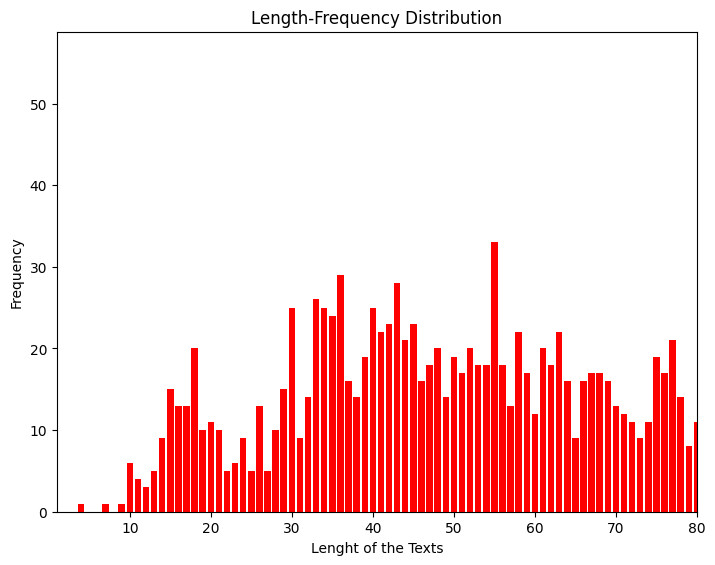

In [ ]:
import matplotlib.pyplot as plt

xx = [x for x, k in frequency1]
yy = [k for x, k in frequency1]
print(xx, yy)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])

ax.bar(xx,yy, color='r')
plt.xlim(1, 80)



plt.xlabel('Lenght of the Texts')
plt.ylabel('Frequency')
plt.title('Length-Frequency Distribution')
plt.show()

In [ ]:
import pandas as pd
import numpy as np

def data_statistics(class_names, data):
  words_per_class = []
  unique_words_per_class = []
  documents_per_class = []

  for label in class_names:
    # Word list from the clean dataset
    word_list = [word.strip().lower() for t in list(data[data.F_type==label].Content) for word in t.strip().split()]
    counts = dict()
    for w in word_list:
      counts[w] = counts.get(w, 0)+1
    # Sort the word list on descending order in terms of frequency
    ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
    # Total words per class
    words_per_class.append(len(word_list))
    # Unique words per class
    unique_words_per_class.append(len(np.unique(word_list)))
    # Number of documents per class
    documents_per_class.append(len(list(data[data.F_type==label].Content)))

    print("Class name: {}".format(label))
    print("Number of words: {}".format(len(word_list)))
    print("Number of unique words: {}".format(len(np.unique(word_list))))
    print("Number of Documents: {}".format(len(list(data[data.F_type==label].Content))))
    print("10 most frequent words:\n")
    for i, f in ordered[:10]:
      print("{}\t{}".format(i, f))

  # Create a dictionary to store the statistics
  statistics = {
    'Class Name': class_names,
    'Number of Words': words_per_class,
    'Number of Unique Words': unique_words_per_class,
    'Number of Documents': documents_per_class
  }

  # Create a DataFrame from the statistics dictionary
  df_statistics = pd.DataFrame(statistics)

  # Print the data distribution table
  print(df_statistics)

  return words_per_class, unique_words_per_class, documents_per_class

# Define your class names
class_names = ['Clickbaits', 'Non-Clickbaits']

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/merge_check.csv')

words1, unique_words1, documents1 = data_statistics(class_names, df)



Class name: Clickbaits
Number of words: 145810
Number of unique words: 27522
Number of Documents: 1750
10 most frequent words:

এই	1659
তার	1089
করে	1037
ও	773
একটি	759
সঙ্গে	752
এক	689
আর	664
থেকে	652
নিয়ে	597
Class name: Non-Clickbaits
Number of words: 178320
Number of unique words: 27980
Number of Documents: 1599
10 most frequent words:

ও	2119
করে	1271
এ	1227
থেকে	1148
করা	1052
এই	974
বুধবার	805
তার	749
এক	735
হয়।	671
       Class Name  Number of Words  Number of Unique Words  \
0      Clickbaits           145810                   27522   
1  Non-Clickbaits           178320                   27980   

   Number of Documents  
0                 1750  
1                 1599  


Class name: Clickbaits
Number of words: 145810
Number of unique words: 27522
Number of Documents: 1750
10 most frequent words:

এই	1659
তার	1089
করে	1037
ও	773
একটি	759
সঙ্গে	752
এক	689
আর	664
থেকে	652
নিয়ে	597
Class name: Non-Clickbaits
Number of words: 178320
Number of unique words: 27980
Number of Documents: 1599
10 most frequent words:

ও	2119
করে	1271
এ	1227
থেকে	1148
করা	1052
এই	974
বুধবার	805
তার	749
এক	735
হয়।	671


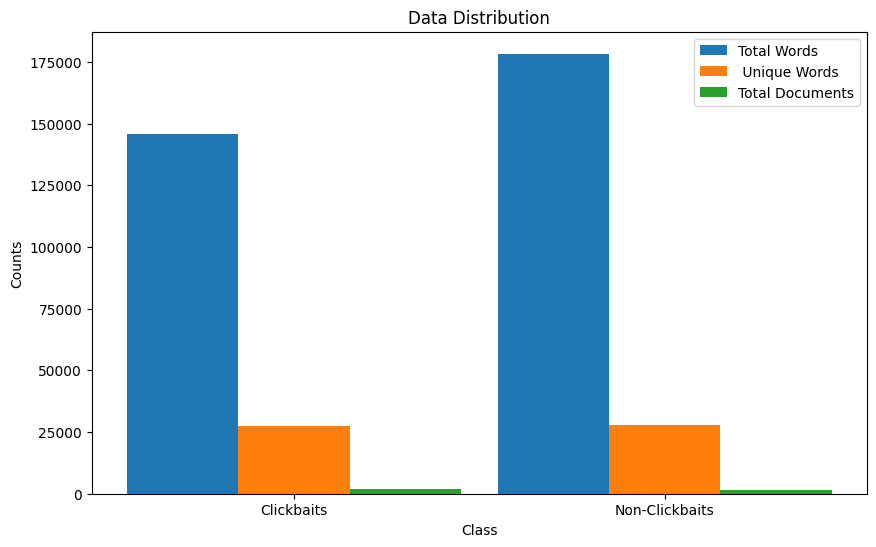

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def data_statistics(class_names, data):
  words_per_class = []
  unique_words_per_class = []
  documents_per_class = []

  for label in class_names:
    # Word list from the clean dataset
    word_list = [word.strip().lower() for t in list(data[data.F_type==label].Content) for word in t.strip().split()]
    counts = dict()
    for w in word_list:
      counts[w] = counts.get(w, 0)+1
    # Sort the word list on descending order in terms of frequency
    ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
    # Total words per class
    words_per_class.append(len(word_list))
    # Unique words per class
    unique_words_per_class.append(len(np.unique(word_list)))
    # Number of documents per class
    documents_per_class.append(len(list(data[data.F_type==label].Content)))

    print("Class name: {}".format(label))
    print("Number of words: {}".format(len(word_list)))
    print("Number of unique words: {}".format(len(np.unique(word_list))))
    print("Number of Documents: {}".format(len(list(data[data.F_type==label].Content))))
    print("10 most frequent words:\n")
    for i, f in ordered[:10]:
      print("{}\t{}".format(i, f))

  # Create a dictionary to store the statistics
  statistics = {
    'Class Name': class_names,
    'Number of Words': words_per_class,
    'Number of Unique Words': unique_words_per_class,
    'Number of Documents': documents_per_class
  }

  # Create a DataFrame from the statistics dictionary
  df_statistics = pd.DataFrame(statistics)

  # Create the histogram diagram
  plt.figure(figsize=(10, 6))
  x = np.arange(len(class_names))
  width = 0.3
  plt.bar(x, words_per_class, width, label='Total Words')
  plt.bar(x + width, unique_words_per_class, width, label=' Unique Words')
  plt.bar(x + 2 * width, documents_per_class, width, label='Total Documents')
  plt.xlabel('Class')
  plt.ylabel('Counts')
  plt.title('Data Distribution')
  plt.xticks(x + width, class_names)
  plt.legend()
  plt.show()

  return words_per_class, unique_words_per_class, documents_per_class

# Define your class names
class_names = ['Clickbaits', 'Non-Clickbaits']

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/merge_check.csv')

words1, unique_words1, documents1 = data_statistics(class_names, df)


Class name: Clickbaits
Number of words: 14906
Number of unique words: 5285
Number of Documents: 1750
10 most frequent words:

এই	222
যা	143
না	115
সঙ্গে	112
ভিডিও	103
ভাইরাল	102
কি	93
:	90
করতে	81
করে	81
Class name: Non-Clickbaits
Number of words: 10647
Number of unique words: 4728
Number of Documents: 1599
10 most frequent words:

২০১৮	72
সেপ্টেম্বর,	69
১৯	66
না	63
প্রধানমন্ত্রী	60
ও	53
থেকে	44
নিয়ে	42
পাকিস্তান	41
:	33


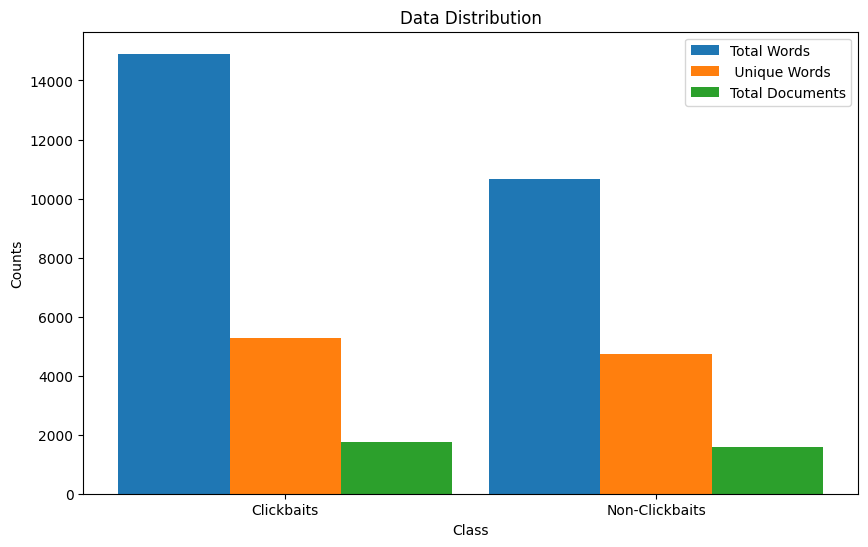

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def data_statistics(class_names, data):
  words_per_class = []
  unique_words_per_class = []
  documents_per_class = []

  for label in class_names:
    # Word list from the clean dataset
    word_list = [word.strip().lower() for t in list(data[data.F_type==label].Headline) for word in t.strip().split()]
    counts = dict()
    for w in word_list:
      counts[w] = counts.get(w, 0)+1
    # Sort the word list on descending order in terms of frequency
    ordered = sorted(counts.items(), key= lambda item: item[1],reverse = True)
    # Total words per class
    words_per_class.append(len(word_list))
    # Unique words per class
    unique_words_per_class.append(len(np.unique(word_list)))
    # Number of documents per class
    documents_per_class.append(len(list(data[data.F_type==label].Headline)))

    print("Class name: {}".format(label))
    print("Number of words: {}".format(len(word_list)))
    print("Number of unique words: {}".format(len(np.unique(word_list))))
    print("Number of Documents: {}".format(len(list(data[data.F_type==label].Headline))))
    print("10 most frequent words:\n")
    for i, f in ordered[:10]:
      print("{}\t{}".format(i, f))

  # Create a dictionary to store the statistics
  statistics = {
    'Class Name': class_names,
    'Number of Words': words_per_class,
    'Number of Unique Words': unique_words_per_class,
    'Number of Documents': documents_per_class
  }

  # Create a DataFrame from the statistics dictionary
  df_statistics = pd.DataFrame(statistics)

  # Create the histogram diagram
  plt.figure(figsize=(10, 6))
  x = np.arange(len(class_names))
  width = 0.3
  plt.bar(x, words_per_class, width, label='Total Words')
  plt.bar(x + width, unique_words_per_class, width, label=' Unique Words')
  plt.bar(x + 2 * width, documents_per_class, width, label='Total Documents')
  plt.xlabel('Class')
  plt.ylabel('Counts')
  plt.title('Data Distribution')
  plt.xticks(x + width, class_names)
  plt.legend()
  plt.show()

  return words_per_class, unique_words_per_class, documents_per_class

# Define your class names
class_names = ['Clickbaits', 'Non-Clickbaits']

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/merge_check.csv')

words1, unique_words1, documents1 = data_statistics(class_names, df)

In [ ]:
pip install wordcloud matplotlib


In [ ]:
pip install nltk

In [ ]:
pip install pandas wordcloud matplotlib nltk

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


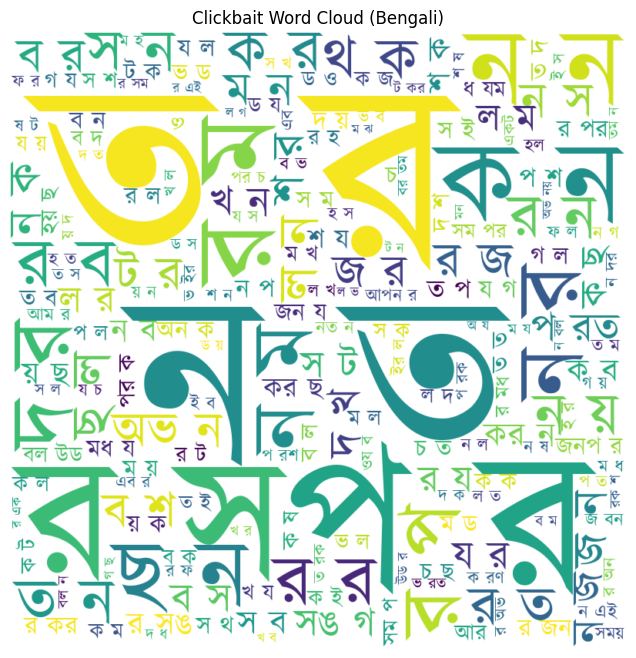

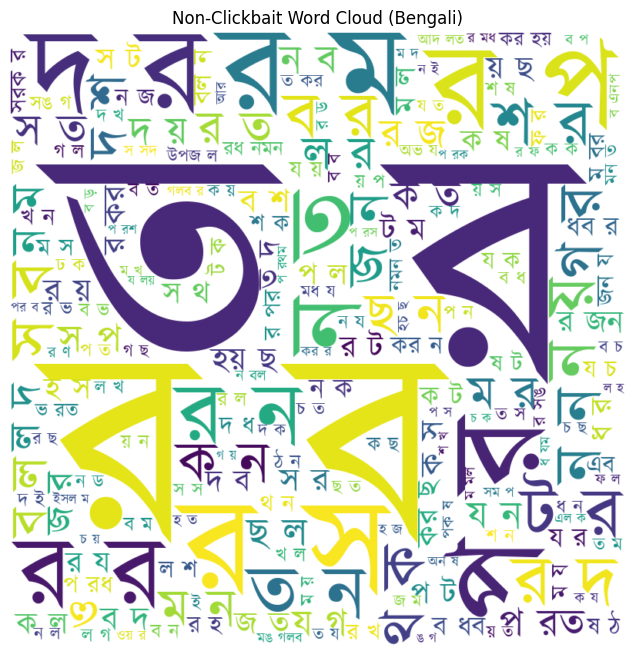

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize

# Download and install necessary resources for Bengali tokenization
nltk.download('punkt')

# Load your dataset
df = pd.read_csv('/content/drive/MyDrive/merge_check.csv')

# Separate the text data for clickbait and non-clickbait classes
clickbait_text = ' '.join(df[df['Label'] == 0]['Headline'] + ' ' + df[df['Label'] == 0]['Content'])
non_clickbait_text = ' '.join(df[df['Label'] == 1]['Headline'] + ' ' + df[df['Label'] == 1]['Content'])

# Tokenize the Bengali text into words
clickbait_words = word_tokenize(clickbait_text)
non_clickbait_words = word_tokenize(non_clickbait_text)

# Combine the words into space-separated strings for word cloud generation
clickbait_words_string = ' '.join(clickbait_words)
non_clickbait_words_string = ' '.join(non_clickbait_words)

# Create WordCloud objects without masks and specify the Bengali font
clickbait_wordcloud = WordCloud(width=800, height=800, background_color='white',
                               font_path='/content/drive/MyDrive/kalpurush.ttf').generate(clickbait_words_string)
non_clickbait_wordcloud = WordCloud(width=800, height=800, background_color='white',
                                   font_path='/content/drive/MyDrive/kalpurush.ttf').generate(non_clickbait_words_string)

# Plot the word clouds using matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(clickbait_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Clickbait Word Cloud (Bengali)')
plt.show()

plt.figure(figsize=(8, 8))
plt.imshow(non_clickbait_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Non-Clickbait Word Cloud (Bengali)')
plt.show()



